In [25]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import collections
import pandas as pd

from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## 1. Create dataset

In [2]:
%run create_dataset_hologram_regression.py

----- Loading hologram dataset... -----
Hologram dataset loaded (matlab file dictionary)
Hologram dataset shape:  (200, 200, 2000)
Total number of holograms: 2000

----- Loading points positions dataset... -----
Points positions dataset loaded (matlab file dictionary)
Points positions dataset shape:  (2000, 3)
Number of point sources per hologram:  1

----- Data pre-procesing... -----
Reshaping hologram dataset to 1 dimension...
Dataset 1D shape:  (2000, 40000)
Computing Y_array...
Y_array shape:  (2000, 3)

----- Spliting dataset... -----
Trainset: 80.0%, testset: 20.0 %
Data :  (2000, 40000) (2000, 3)
Train:  (1600, 40000) (1600, 3)
Test :  (400, 40000) (400, 3)
X_train, Y_train, X_test, Y_test saved in .npy files!

Done!
Execution time: 60.9104 seconds


# 2. Prepare dataset

In [3]:
def load_data():
    '''
    Load the datasets in .npy format.
    '''
    x_train = np.load('X_train.npy')
    y_train = np.load('Y_train.npy')

    x_test = np.load('X_test.npy')
    y_test = np.load('Y_test.npy')

    return x_train, y_train, x_test, y_test

In [4]:
# Load .npy files
X_train, Y_train, X_test, Y_test = load_data()

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1600, 40000) (1600, 3)
(400, 40000) (400, 3)


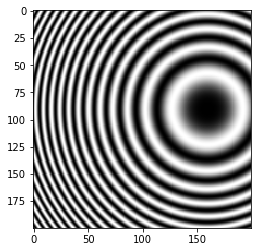

[ 6.00661151e-04 -9.24045825e-05 -2.16195752e-01]


In [12]:
hol = X_train[0, :]
img = np.reshape(hol, (200, 200))

plt.imshow(np.real(img), cmap='gray')
plt.show()

print(Y_train[0, :])

In [13]:
def normalize(arr):

    max_value = np.max(np.max(arr, axis=0))
    min_value = np.min(np.min(arr, axis=0))
    arr = (arr - min_value) / (max_value - min_value)

    return arr

In [14]:
def normalize_dataset(data_1D):

    # Normalize the examples
    data_1D_norm = np.zeros([data_1D.shape[0], data_1D.shape[1]], dtype=complex)

    # Normalize each example
    for i in range(data_1D.shape[0]):
        data_1D_norm[i, :] = normalize(data_1D[i, :])

    return data_1D_norm

In [15]:
X_train_norm = normalize_dataset(X_train)
X_test_norm = normalize_dataset(X_test)

In [16]:
df = pd.DataFrame(X_train)
df

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,40.797396+12.898421j,34.865701-24.802841j,1.443639-42.763479j,-32.955579-27.289748j,-41.798404+9.148505j,-18.766444+38.452874j,18.281026+38.686021j,41.564737+10.157655j,34.213149-25.695660j,2.077979-42.737451j,...,-34.852989+24.822322j,-38.730195+18.189289j,-41.421752+10.729234j,-42.706468+2.652414j,-42.398226-5.767835j,-40.364066-14.199275j,-36.542663-22.260069j,-30.961787-29.533784j,-23.753035-35.590303j,-15.161897-40.012409j
1,412.746377+181.670432j,-403.904923-200.564292j,389.999424+226.422539j,-369.635613-258.336440j,341.166832+294.915025j,-302.847122-334.147823j,253.055163+373.276961j,-190.600269-408.712114j,115.111325+436.033115j,-27.491191-450.134602j,...,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
2,-11.439904+1.757902j,-11.202009+2.911464j,-10.860255+4.002062j,-10.427837+5.022138j,-9.917945+5.966239j,-9.343508+6.830850j,-8.716973+7.614199j,-8.050142+8.316061j,-7.354038+8.937549j,-6.638822+9.480913j,...,8.228795+8.139170j,3.622292+10.992640j,-1.812736+11.431234j,-6.873611+9.311958j,-10.405192+5.068634j,-11.568378-0.362858j,-10.049770-5.741180j,-6.158465-9.799607j,-0.778916-11.547825j,4.818508-10.523351j
3,-18.689387-46.574521j,-49.336419-9.186892j,-34.431198+36.509941j,11.753150+48.788817j,47.172915+17.123178j,40.499817-29.635350j,-1.732602-50.154652j,-42.279041-27.036562j,-46.376346+19.176273j,-11.146612+48.931073j,...,18.170704-46.778629j,26.716362-42.481174j,34.521343-36.423765j,41.169771-28.696051j,46.242998-19.493540j,49.347046-9.125871j,50.144633+1.981888j,48.390123+13.296904j,43.964998+24.196902j,36.910628+34.000238j
4,-8.966445+16.229104j,-1.950599+18.438443j,5.304292+17.766417j,11.685125+14.395798j,16.261932+8.906782j,18.414514+2.164934j,17.902839-4.823867j,14.876404-11.066797j,9.827324-15.722760j,3.499500-18.208103j,...,5.257654+17.780245j,-0.743402+18.526396j,-6.731528+17.276182j,-12.040957+14.099476j,-16.045235+9.291407j,-18.235154+3.355430j,-18.290171-3.041273j,-16.133226-9.137760j,-11.959609-14.168533j,-6.232787-17.462299j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,5.162689+6.768178j,7.586094+3.861708j,8.509746+0.214116j,7.779687-3.455154j,5.563642-6.442633j,2.306520-8.193998j,-1.364147-8.402426j,-4.762066-7.055806j,-7.270585-4.427220j,-8.451842-1.013933j,...,-1.404858+8.395808j,-1.775106+8.325396j,-2.163226+8.233084j,-2.567644+8.116059j,-2.986458+7.971467j,-3.417405+7.796445j,-3.857835+7.588170j,-4.304682+7.343904j,-4.754445+7.061053j,-5.203170+6.737227j
1596,-124.394473-60.043045j,-137.649194-11.483058j,-133.019620+37.214929j,-112.548893+80.074501j,-79.950499+112.637051j,-39.839101+132.257483j,2.993860+138.095041j,44.169366+130.875049j,80.128711+112.510481j,108.352349+85.667931j,...,79.570076-112.912784j,109.058841+84.775128j,-90.884858+104.021895j,-97.628158-97.720588j,105.049850-89.694247j,80.040867+112.578625j,-119.944968+68.510215j,-54.987337-126.715411j,132.385817-39.425313j,21.873666+136.388635j
1597,3.675313+9.054183j,3.694695+9.046291j,3.688940+9.048640j,3.658029+9.061180j,3.601858+9.083654j,3.520242+9.115594j,3.412924+9.156315j,3.279579+9.204918j,3.119832+9.260281j,2.933272+9.321055j,...,9.429652+2.562575j,6.871064+6.947920j,2.431253+9.464360j,-2.697800+9.391856j,-7.102100+6.711575j,-9.535241+2.136405j,-9.278398-3.065347j,-6.365296-7.414042j,-1.599043-9.639919j,3.655797-9.062015j
1598,31.414501-4.235602j,24.208655-20.463445j,9.558475-30.223294j,-7.886036-30.702162j,-22.830714-21.990251j,-30.942183-6.884353j,-30.051545+10.085534j,-20.645073+24.053994j,-5.567894+31.205970j,10.903599+29.764507j,...,31.305687+4.973227j,27.182385+16.306340j,18.997751+25.374475j,7.838218+30.713851j,-4.672103+31.352025j,-16.588118+27.011333j,-25.940359+18.217444j,-31.069842+6.280302j,-30.945490-6.866851j,-25.402707-18.959937j


In [17]:
df = pd.DataFrame(X_train_norm)
df

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,0.976776+0.150706j,0.907311-0.289816j,0.516696-0.499554j,0.114798-0.318602j,0.011615+0.107221j,0.280866+0.449555j,0.713773+0.452129j,0.985732+0.118676j,0.899682-0.300246j,0.524109-0.499252j,...,0.092837+0.290344j,0.047504+0.212852j,0.016023+0.125691j,0.000978+0.031317j,0.004546-0.067076j,0.028281-0.165607j,0.072902-0.259815j,0.138087-0.344832j,0.222298-0.415632j,0.322669-0.467340j
1,0.957991+0.200377j,0.051760-0.221060j,0.932900+0.250043j,0.089586-0.285189j,0.878961+0.326095j,0.163407-0.369402j,0.781512+0.413193j,0.287619-0.452357j,0.628785+0.483130j,0.468297-0.498716j,...,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j,0.500001+0.000142j
2,0.005813+0.075973j,0.016098+0.125805j,0.030869+0.172916j,0.049556+0.216980j,0.071589+0.257761j,0.096410+0.295108j,0.123482+0.328944j,0.152293+0.359260j,0.182369+0.386103j,0.213269+0.409572j,...,0.855535+0.351509j,0.656555+0.474809j,0.421767+0.493792j,0.203125+0.402274j,0.050534+0.218988j,0.000249-0.015642j,0.065816-0.247993j,0.233891-0.423341j,0.466274-0.498900j,0.708087-0.454680j
3,0.314004-0.464484j,0.008505-0.092128j,0.156803+0.363212j,0.616880+0.485750j,0.969905+0.170423j,0.903628-0.295459j,0.482959-0.500077j,0.078896-0.269932j,0.037870+0.190465j,0.388731+0.487066j,...,0.681240-0.466355j,0.766361-0.423502j,0.844094-0.363118j,0.910298-0.286097j,0.960802-0.194391j,0.991681-0.091085j,0.999579+0.019585j,0.982049+0.132308j,0.937913+0.240884j,0.867588+0.338523j
4,0.258260+0.437786j,0.447461+0.497341j,0.643098+0.479194j,0.815156+0.388279j,0.938558+0.240244j,0.996583+0.058432j,0.982762-0.130030j,0.901128-0.298371j,0.764956-0.423909j,0.594308-0.490909j,...,0.641840+0.479567j,0.480015+0.499709j,0.318531+0.466015j,0.175344+0.380368j,0.067346+0.250724j,0.008271+0.090658j,0.006766-0.081839j,0.064911-0.246247j,0.177443-0.381924j,0.331865-0.470765j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.803185+0.397524j,0.945552+0.226826j,0.999834+0.012586j,0.956983-0.202942j,0.826843-0.378435j,0.635544-0.481331j,0.419942-0.493604j,0.220348-0.414535j,0.072984-0.260160j,0.003573-0.059684j,...,0.417415+0.493073j,0.395668+0.488934j,0.372872+0.483508j,0.349118+0.476632j,0.324520+0.468135j,0.299209+0.457851j,0.273341+0.445614j,0.247096+0.431263j,0.220681+0.414646j,0.194327+0.395622j
1596,0.049901-0.216701j,0.001816-0.040973j,0.018462+0.135296j,0.092457+0.290469j,0.210370+0.408400j,0.355505+0.479506j,0.510522+0.500732j,0.659569+0.474693j,0.789763+0.408306j,0.891977+0.311216j,...,0.788253-0.407595j,0.894536+0.307986j,0.170813+0.377194j,0.146865-0.353011j,0.880422-0.323500j,0.789445+0.408553j,0.065713+0.248596j,0.301266-0.457858j,0.979248-0.141494j,0.578859+0.494599j
1597,0.688065+0.463637j,0.689057+0.463233j,0.688762+0.463353j,0.687180+0.463995j,0.684306+0.465145j,0.680130+0.466779j,0.674639+0.468863j,0.667816+0.471350j,0.659642+0.474183j,0.650096+0.477293j,...,0.982498+0.131470j,0.851584+0.355861j,0.624409+0.484626j,0.361966+0.480920j,0.136605+0.343778j,0.012103+0.109678j,0.025241-0.156486j,0.174296-0.379002j,0.418174-0.492899j,0.687053-0.463332j
1598,0.995532-0.066670j,0.881949-0.322671j,0.650914-0.476686j,0.375758-0.484323j,0.139989-0.346979j,0.011972-0.108747j,0.025939+0.158929j,0.174244+0.379303j,0.412027+0.492185j,0.671844+0.469527j,...,0.993771+0.078584j,0.928679+0.257325j,0.799537+0.400320j,0.623488+0.484487j,0.426156+0.494493j,0.238221+0.425969j,0.090747+0.287216j,0.009896+0.098903j,0.011920-0.108471j,0.099406-0.299193j


# 3. Neural network

In [20]:
# 1. Create the model

model = Sequential()  # build a model layer by layer

In [23]:
# 2. Add model layers

# First layer (hidden layer)
nb_nodes1 = 1000
input_dim1 = X_train.shape[1] # 40000 
activation1 = 'relu' # Rectified linear unit (ReLU)

model.add(Dense(1000, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Second layer (hidden layer)
nb_nodes2 = 400
activation2 = 'relu' # Rectified linear unit (ReLU)

model.add(Dense(400, kernel_initializer='normal', activation='relu'))

# Third layer (output layer)
activation3 = 'softmax'
model.add(Dense(3, kernel_initializer='normal', activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
# Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              40001000  
_________________________________________________________________
dense_2 (Dense)              (None, 400)               400400    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1203      
Total params: 40,402,603
Trainable params: 40,402,603
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 3. Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
# # 4. Train the model
# X_train = X_data
# Y_train = np.reshape(Y_data, (-1,1))
# Y_train.shape

In [ ]:
%%time
# Train the model
nb_epochs = 5

history = model.fit(X_train_norm, Y_train, validation_data=(X_test_norm, Y_test), epochs=nb_epochs, verbose=1)

In [2]:

def normalize(arr):

    max_value = np.max(np.max(arr, axis=0))
    min_value = np.min(np.min(arr, axis=0))
    arr = (arr - min_value) / (max_value - min_value)

    return arr

def normalize_dataset(nb_holograms, data_1D):

    # Normalize the examples
    data_1D_norm = np.zeros([nb_holograms, data_1D.shape[1]], dtype=complex)

    # Normalize each example
    for i in range(nb_holograms):
        data_1D_norm[i, :] = normalize(data_1D[i, :])

    return data_1D_norm


def pre_processing(dat, nb_holograms, nb_class, nb_holograms_class):

    print('----- Data pre-procesing... -----')

    # Reshape the dataset to 1 dimension
    print('Reshaping dataset to 1 dimension...')
    data_1D = reshape_dataset(dat, nb_holograms)
    print('Dataset 1D shape: ', data_1D.shape)

    # Normalize the data
    print('Normalizing dataset...')
    data_1D_norm = normalize_dataset(nb_holograms, data_1D)
    print('Normalized dataset shape: ', data_1D_norm.shape)

    # Compute array of targets
    print('Computing Y_array...')
    Y_array = compute_targets_array(nb_holograms, nb_class, nb_holograms_class)

    # Verify
    print('Y_array shape: ', Y_array.shape)
    print(collections.Counter(Y_array))
    print('Y_array saved in a .npy file!\n')

    return data_1D_norm, Y_array

In [3]:
dat, nb_holograms, nb_class, nb_holograms_class = load_dataset()

# Prepare dateset (reshape, normalize, target's array)
data_1D_norm, Y_array = pre_processing(dat, nb_holograms, nb_class, nb_holograms_class)

----- Loading hologram dataset... -----
Hologram dataset loaded (matlab file dictionary)
Hologram dataset shape:  (200, 200, 1500)
Total number of holograms: 1500
Number of holograms per class: 300
Hologram dataset saved in .npy file!

----- Data pre-procesing... -----
Reshaping dataset to 1 dimension...
Dataset 1D shape:  (1500, 40000)
Normalizing dataset...
Normalized dataset shape:  (1500, 40000)
Computing Y_array...
Y_array shape:  (1500,)
Counter({0.0: 300, 1.0: 300, 2.0: 300, 3.0: 300, 4.0: 300})
Y_array saved in a .npy file!



In [4]:
data_1D_norm.shape

(1500, 40000)

In [5]:
dataset = data_1D_norm

In [6]:
def load_points_dataset():
    
    # Current directory
    cwd = os.getcwd()

    # Directory path
    path = str((Path(cwd).parent).parent)
    file_path = path + '\\output\\dataset\\'

    # File names
    file_name = 'pDataset.mat'
    key = 'pDataset'

    points = load_matlab_dictionary(file_path, file_name, key)
    
    return points

In [7]:
points_dataset = load_points_dataset()
points_dataset.shape

(4500, 3)

In [8]:
def positions_points_dataset(class_nb, nb_holograms_class):
    
    # Initial position in the points dataset
    init = 0
    for nb in range(1, class_nb):
        init = nb * nb_holograms_class + init
    
    # Final position in the points dataset
    fin = 0
    for nb in range(1, class_nb + 1):
        fin = nb * nb_holograms_class + fin
    fin = fin - 1

    return init, fin

In [9]:
def load_points_dataset_one_class(data, class_nb, nb_holograms_class):
    
    # Initial and final position in the points dataset
    init, fin = positions_points_dataset(class_nb, nb_holograms_class)

    points_one_class = data[init:(fin + 1), :]
    
    return points_one_class

In [10]:
class_nb = 1

p_dataset  = load_points_dataset_one_class(points_dataset, class_nb, nb_holograms_class)
p_dataset.shape

(300, 3)

In [11]:
X_data = dataset[0:300,:]
X_data.shape

(300, 40000)

In [12]:
Y_data = p_dataset[:,0]
Y_data.shape

(300,)

In [13]:
y = pd.DataFrame(Y_data)
y

,0
0,0.000786
1,0.000523
2,-0.000766
3,-0.000760
4,-0.000875
...,...
295,0.000811
296,-0.000422
297,0.000612
298,-0.000538


In [14]:
# Create the model
model = Sequential()  # build a model layer by layer

In [15]:
X_data.shape[1]

40000

In [16]:

# Add model layers

# First layer (hidden layer)
nb_nodes1 = 1000
input_dim1 = X_data.shape[1] # 40000 
activation1 = 'relu' # Rectified linear unit (ReLU)

model.add(Dense(nb_nodes1, input_dim=input_dim1, activation=activation1))

# Second layer (hidden layer)
nb_nodes2 = 400
activation2 = 'relu' # Rectified linear unit (ReLU)

model.add(Dense(nb_nodes2, activation=activation2))

# Third layer (output layer)
activation3 = 'softmax'
model.add(Dense(1, activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              40001000  
_________________________________________________________________
dense_2 (Dense)              (None, 400)               400400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 40,401,801
Trainable params: 40,401,801
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [19]:
X_train = X_data
Y_train = np.reshape(Y_data, (-1,1))
Y_train.shape

(300, 1)

In [20]:
%%time
# Train the model
nb_epochs = 50
nb_batchs = 1000

history = model.fit(X_train, Y_train, epochs=nb_epochs, verbose=1)


Epoch 1/50


c:\users\flucasamar\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


300/300 [==============================] - 3s 11ms/step - loss: 5592.0955 - mse: 5592.0957
Epoch 2/50
300/300 [==============================] - 3s 11ms/step - loss: 50.1365 - mse: 50.1365
Epoch 3/50
300/300 [==============================] - 3s 11ms/step - loss: 13.6090 - mse: 13.6090
Epoch 4/50
300/300 [==============================] - 3s 11ms/step - loss: 4.4229 - mse: 4.4229
Epoch 5/50
300/300 [==============================] - 3s 11ms/step - loss: 1.6201 - mse: 1.6201
Epoch 6/50
300/300 [==============================] - 3s 11ms/step - loss: 0.6099 - mse: 0.6099
Epoch 7/50
300/300 [==============================] - 3s 11ms/step - loss: 0.3038 - mse: 0.3038
Epoch 8/50
300/300 [==============================] - 3s 11ms/step - loss: 0.2691 - mse: 0.2691
Epoch 9/50
300/300 [==============================] - 3s 11ms/step - loss: 0.1345 - mse: 0.1345
Epoch 10/50
300/300 [==============================] - 3s 11ms/step - loss: 0.0753 - mse: 0.0753
Epoch 11/50
300/300 [===================

dict_keys(['loss', 'mse'])


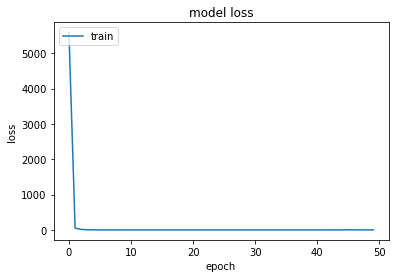

In [21]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [30]:
predictions = model.predict(X_train)
df = pd.DataFrame(predictions)
df

,0
0,-0.226264
1,-0.008546
2,-0.667060
3,-0.460076
4,-0.357089
...,...
295,-0.445419
296,-0.613450
297,-0.475568
298,-0.299968


In [ ]:
┬

In [101]:
# Compile the model
loss_fct = 'categorical_crossentropy' # Used for classification problem
opt_fct = 'adam' # Popular version of Gradient Descent
metrics_fct = ['accuracy'] # Classification problem

model.compile(loss=loss_fct, optimizer=opt_fct, metrics=metrics_fct)

# Train the model
nb_epochs = 50
nb_batchs = 1000

history = model.fit(X_data, Y_data, epochs=nb_epochs, verbose=1)

ValueError: You are passing a target array of shape (300, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

## Example

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [32]:
#Variables
# d = np.loadtxt("cars.csv", delimiter=",")
dataframe = pd.read_csv("cars.csv", delimiter=",")
dataframe

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


In [42]:
dataset = dataframe.values
x = dataset[:,0:5]
y = dataset[:,5]
print(y.shape)
print(type(y))
y = np.reshape(y, (-1,1))
print(y.shape)
print(type(y))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

(963,)
<class 'numpy.ndarray'>
(963, 1)
<class 'numpy.ndarray'>
MinMaxScaler()
MinMaxScaler()


In [49]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

In [50]:
X_train.shape

(722, 5)

In [51]:
model = Sequential()
model.add(Dense(12, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [53]:
>>> history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 577 samples, validate on 145 samples
Epoch 1/150
577/577 [==============================] - 0s 260us/sample - loss: 0.2518 - mean_squared_error: 0.2518 - mean_absolute_error: 0.3954 - val_loss: 0.2213 - val_mean_squared_error: 0.2213 - val_mean_absolute_error: 0.3762
Epoch 2/150
577/577 [==============================] - 0s 38us/sample - loss: 0.1607 - mean_squared_error: 0.1607 - mean_absolute_error: 0.2929 - val_loss: 0.1343 - val_mean_squared_error: 0.1343 - val_mean_absolute_error: 0.2788
Epoch 3/150
577/577 [==============================] - 0s 36us/sample - loss: 0.0934 - mean_squared_error: 0.0934 - mean_absolute_error: 0.2359 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2357
Epoch 4/150
577/577 [==============================] - 0s 36us/sample - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.2179 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.2212
Epoch 5/150
577/577 [============

577/577 [==============================] - 0s 26us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0789 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0953
Epoch 72/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0792 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0945
Epoch 73/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0788 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0957
Epoch 74/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0792 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0943
Epoch 75/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0112 - m

577/577 [==============================] - 0s 24us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0756 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0888
Epoch 142/150
577/577 [==============================] - 0s 28us/sample - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0751 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0918
Epoch 143/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0756 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0891
Epoch 144/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0749 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0899
Epoch 145/150
577/577 [==============================] - 0s 24us/sample - loss: 0.0103

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


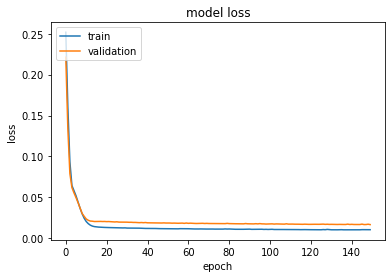

In [54]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [55]:
Xnew = np.array([[40, 0, 26, 9000, 8000]])

In [73]:
Xnew = np.array([[40, 0, 26, 9000, 8000]])
Xnew= scaler_x.transform(Xnew)
ynew= model.predict(Xnew)
#invert normalize
ynew = scaler_y.inverse_transform(y_test) 
Xnew = scaler_x.inverse_transform(X_test)
pos = 20
print("X = %s, Predicted = %s" % (Xnew[pos, 4], ynew[pos]))

X = 4221.0, Predicted = [14767.]
